In [ ]:
import requests
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
import matplotlib.pyplot as plt
import warnings

from google.colab import files

uploaded = files.upload()
import warnings
warnings.filterwarnings("ignore")


Saving sensor_data.csv to sensor_data.csv


In [ ]:
df=pd.read_csv('sensor_data.csv')
df

,Index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,0,30/8/2023,21:18:38,0.00,0.00,218.0,0.00,0.00,0.00
1,1,30/8/2023,21:18:39,16.51,5.43,216.0,80.46,8.38,8.13
2,2,30/8/2023,21:18:40,0.33,0.11,220.0,1.57,0.33,0.00
3,3,30/8/2023,21:18:41,1.87,0.61,216.0,9.11,0.97,0.90
4,4,30/8/2023,21:18:42,18.22,5.99,218.0,88.00,9.11,9.11
...,...,...,...,...,...,...,...,...,...
996,996,30/8/2023,21:35:20,9.57,3.14,218.0,46.20,4.56,5.01
997,997,30/8/2023,21:35:21,18.38,6.04,216.0,89.57,9.35,9.03
998,998,30/8/2023,21:35:22,18.22,5.99,218.0,88.00,9.11,9.11
999,999,30/8/2023,21:35:23,18.22,5.99,218.0,88.00,9.11,9.11


In [ ]:
import pandas as pd


# Combine 'Date' and 'Time' columns into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.set_index('Datetime')

# Drop the original 'Date' and 'Time' columns
df = df.drop(['Date', 'Time'], axis=1)

# Sort the DataFrame by datetime
df = df.sort_index()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the data into training (80%), validation (10%), and test (10%)
train_data, remaining_data = train_test_split(df, test_size=0.2, shuffle=False)
val_data, test_data = train_test_split(remaining_data, test_size=0.5, shuffle=False)

def create_sequences(data, sequence_length):
    sequences = []
    targets = []

    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        target = data.iloc[i+sequence_length][['Global_active_power', 'Global_reactive_power']]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

sequence_length = 10  # Adjust as needed
input_features = ['Global_active_power', 'Global_reactive_power']
output_features = ['Global_active_power', 'Global_reactive_power']
# Create sequences and targets for training, validation, and test
train_sequences, train_targets = create_sequences(train_data[input_features], sequence_length)
val_sequences, val_targets = create_sequences(val_data[input_features], sequence_length)
test_sequences, test_targets = create_sequences(test_data[input_features], sequence_length)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

# Input layer
input_layer = Input(shape=(sequence_length, len(input_features)))

# Shared LSTM layer
shared_lstm = LSTM(64, activation='relu')(input_layer)

# Output layers
active_power_output = Dense(1, name='active_power')(shared_lstm)
reactive_power_output = Dense(1, name='reactive_power')(shared_lstm)

# Define the model with two outputs
model = Model(inputs=input_layer, outputs=[active_power_output, reactive_power_output])

# Compile the model with appropriate loss functions
model.compile(optimizer='adam', loss={'active_power': 'mean_squared_error', 'reactive_power': 'mean_squared_error'})


In [ ]:
history = model.fit(train_sequences, {'active_power': train_targets[:, 0], 'reactive_power': train_targets[:, 1]},
                    validation_data=(val_sequences, {'active_power': val_targets[:, 0], 'reactive_power': val_targets[:, 1]}),
                    epochs=50, batch_size=32)


Epoch 1/50
25/25 [==============================] - 4s 45ms/step - loss: 105.2583 - active_power_loss: 92.2816 - reactive_power_loss: 12.9767 - val_loss: 77.8604 - val_active_power_loss: 66.2918 - val_reactive_power_loss: 11.5686
Epoch 2/50
25/25 [==============================] - 1s 20ms/step - loss: 37.4165 - active_power_loss: 32.2703 - reactive_power_loss: 5.1461 - val_loss: 119.7448 - val_active_power_loss: 110.1238 - val_reactive_power_loss: 9.6210
Epoch 3/50
25/25 [==============================] - 0s 10ms/step - loss: 18.1403 - active_power_loss: 15.9035 - reactive_power_loss: 2.2368 - val_loss: 78.9583 - val_active_power_loss: 71.7129 - val_reactive_power_loss: 7.2454
Epoch 4/50
25/25 [==============================] - 0s 11ms/step - loss: 14.3668 - active_power_loss: 12.8942 - reactive_power_loss: 1.4726 - val_loss: 57.9947 - val_active_power_loss: 52.9121 - val_reactive_power_loss: 5.0826
Epoch 5/50
25/25 [==============================] - 0s 12ms/step - loss: 12.9630 - acti

In [ ]:
test_loss = model.evaluate(test_sequences, {'active_power': test_targets[:, 0], 'reactive_power': test_targets[:, 1]})
print(f'Test Loss (Active Power): {test_loss[0]}')
print(f'Test Loss (Reactive Power): {test_loss[1]}')


3/3 [==============================] - 0s 10ms/step - loss: 201.8967 - active_power_loss: 182.8265 - reactive_power_loss: 19.0702
Test Loss (Active Power): 201.8966827392578
Test Loss (Reactive Power): 182.8264923095703


In [ ]:
# Example: Predict the next values in the time series
num_features = len(input_features)
latest_sequence = test_sequences[-1].reshape(1, sequence_length, num_features)
predicted_values = model.predict(latest_sequence)
print(f'Predicted Active Power: {predicted_values[0][0]}')
print(f'Predicted Reactive Power: {predicted_values[1][0]}')


1/1 [==============================] - 0s 220ms/step
Predicted Active Power: [8.932068]
Predicted Reactive Power: [2.0515957]


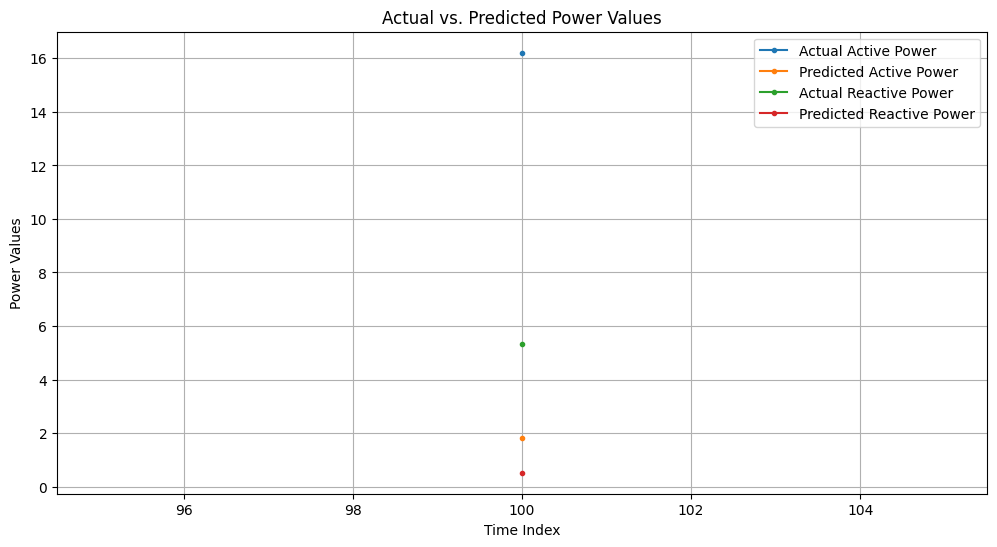

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the actual values for 'Global_active_power' and 'Global_reactive_power'
actual_active_power = test_targets[:, 0]
actual_reactive_power = test_targets[:, 1]

# Extract the predicted values for 'Global_active_power' and 'Global_reactive_power'
predicted_active_power = predicted_values[0][:, 0]
predicted_reactive_power = predicted_values[1][:, 0]

# Calculate the time index for the entire predicted sequence
num_predictions = len(predicted_active_power)
time_index_predicted = range(len(test_data) - num_predictions, len(test_data))

# Create a time series plot to visualize the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_index_predicted, actual_active_power[-num_predictions:], label='Actual Active Power', linestyle='-', marker='o', markersize=3)
plt.plot(time_index_predicted, predicted_active_power, label='Predicted Active Power', linestyle='-', marker='o', markersize=3)
plt.plot(time_index_predicted, actual_reactive_power[-num_predictions:], label='Actual Reactive Power', linestyle='-', marker='o', markersize=3)
plt.plot(time_index_predicted, predicted_reactive_power, label='Predicted Reactive Power', linestyle='-', marker='o', markersize=3)

# Customize the plot
plt.xlabel('Time Index')
plt.ylabel('Power Values')
plt.title('Actual vs. Predicted Power Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


Active Power Metrics:
MAE: 14.39
MSE: 207.15
RMSE: 14.39
Reactive Power Metrics:
MAE: 4.81
MSE: 23.15
RMSE: 4.81


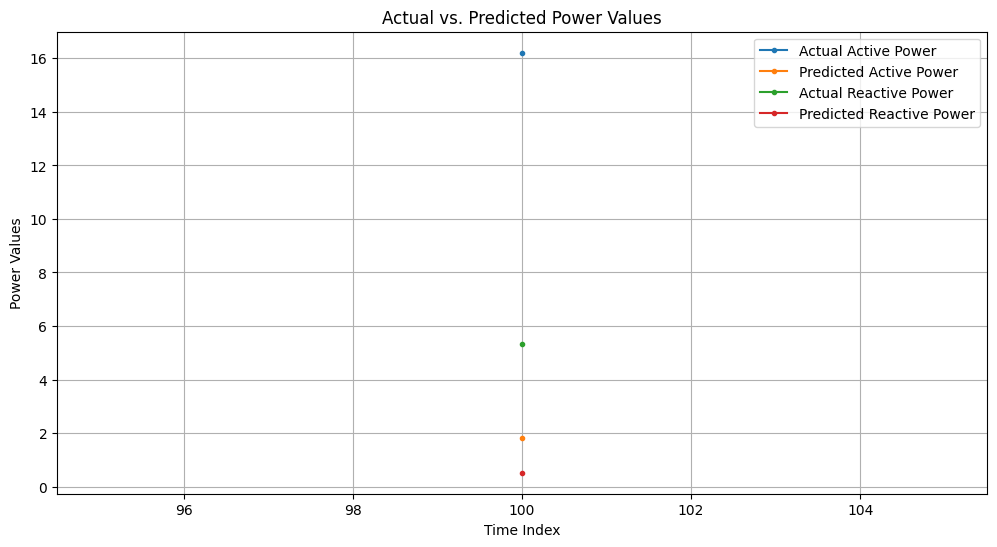

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate evaluation metrics for active power predictions
mae_active_power = mean_absolute_error(actual_active_power[-num_predictions:], predicted_active_power)
mse_active_power = mean_squared_error(actual_active_power[-num_predictions:], predicted_active_power)
rmse_active_power = np.sqrt(mse_active_power)

# Calculate evaluation metrics for reactive power predictions
mae_reactive_power = mean_absolute_error(actual_reactive_power[-num_predictions:], predicted_reactive_power)
mse_reactive_power = mean_squared_error(actual_reactive_power[-num_predictions:], predicted_reactive_power)
rmse_reactive_power = np.sqrt(mse_reactive_power)

# Print the metrics
print(f'Active Power Metrics:')
print(f'MAE: {mae_active_power:.2f}')
print(f'MSE: {mse_active_power:.2f}')
print(f'RMSE: {rmse_active_power:.2f}')

print(f'Reactive Power Metrics:')
print(f'MAE: {mae_reactive_power:.2f}')
print(f'MSE: {mse_reactive_power:.2f}')
print(f'RMSE: {rmse_reactive_power:.2f}')

# Create a time series plot to visualize the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_index_predicted, actual_active_power[-num_predictions:], label='Actual Active Power', linestyle='-', marker='o', markersize=3)
plt.plot(time_index_predicted, predicted_active_power, label='Predicted Active Power', linestyle='-', marker='o', markersize=3)
plt.plot(time_index_predicted, actual_reactive_power[-num_predictions:], label='Actual Reactive Power', linestyle='-', marker='o', markersize=3)
plt.plot(time_index_predicted, predicted_reactive_power, label='Predicted Reactive Power', linestyle='-', marker='o', markersize=3)

# Customize the plot
plt.xlabel('Time Index')
plt.ylabel('Power Values')
plt.title('Actual vs. Predicted Power Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


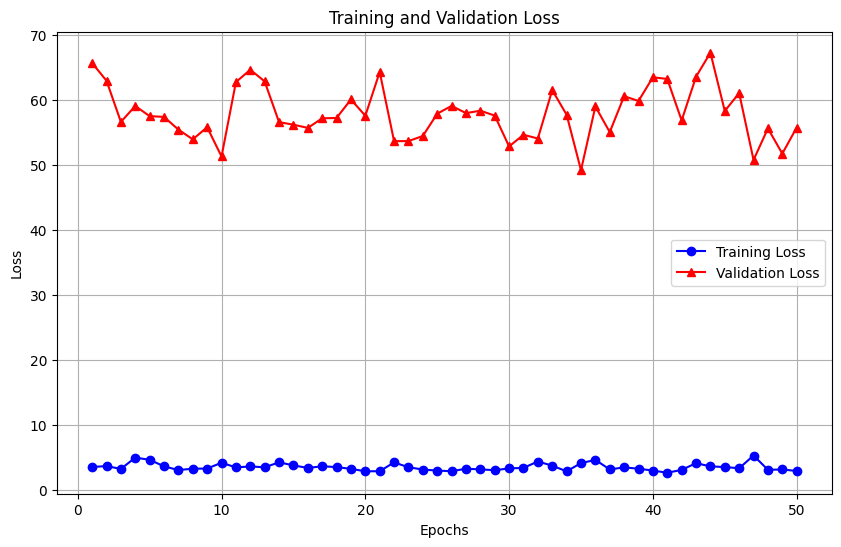

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a 'history' variable with recorded training history
training_loss = history.history['loss']  # Replace with your loss metric name
validation_loss = history.history['val_loss']  # Replace with your validation loss metric name

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r^-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()
